In [1]:
import joblib
import nltk
import time
import random
import datetime
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from os import path
from dateutil import parser
from bs4 import BeautifulSoup
from selenium.common.exceptions import NoSuchElementException
from selenium import webdriver

In [4]:
class ReutersCrawlerV2:
    
    def __init__(self):
        self.SP500_list = open("../data/SP500.txt", 'r').read().split('\n')
        self.driver_path = r"./chromedriver.exe"
        
    def scroll_to_bottom(self):
        old_position = 0
        new_position = None

        while new_position != old_position:
            # Get old scroll position
            old_position = self.driver.execute_script(
                    ("return (window.pageYOffset !== undefined) ?"
                     " window.pageYOffset : (document.documentElement ||"
                     " document.body.parentNode || document.body);"))
            # Scroll down page
            time.sleep(1)
            self.driver.execute_script((
                    "var scrollingElement = (document.scrollingElement ||"
                    " document.body);scrollingElement.scrollTop ="
                    " scrollingElement.scrollHeight;"))
            time.sleep(random.randint(2, 4))
            # Get new position
            new_position = self.driver.execute_script(
                    ("return (window.pageYOffset !== undefined) ?"
                     " window.pageYOffset : (document.documentElement ||"
                     " document.body.parentNode || document.body);"))
            
    def get_article_and_time(self, url):
        article, name, date = None, None, None
        res = requests.get(url)
        soup = BeautifulSoup(res.text, "html.parser")
        article_body = soup.find(name="div", attrs={"class": "StandardArticleBody_body"})
        article = "".join([p.text for p in article_body.find_all("p", text=True) if article_body is not None])
        if soup.find(name="div", attrs={"class": "ArticleHeader_date"}) is not None: 
            date = soup.find(name="div", attrs={"class": "ArticleHeader_date"}).text
            date = date.split("/")[0] + date.split("/")[1]
            date = pd.to_datetime(date)
        
        return article, date
            
    def parse(self):
        df = pd.DataFrame()
        for url in tqdm(self.SP500_list):
            try: 
                self.driver = webdriver.Chrome(self.driver_path)
                self.driver.get(url)
                time.sleep(random.randint(1, 2))
                self.scroll_to_bottom()
                soup = BeautifulSoup(self.driver.page_source, "html.parser")
                self.driver.quit()
                table = soup.find(name="div", attrs={"class": "FeedScroll-feed-container-106s7"})

                url_list = []
                for block in table.find_all(name="div", attrs={"class": "item"}):
                    news_title = block.find(name="a").text
                    news_summary = block.find(name="p").text
                    news_url = block.find(name="a").get("href")
                    query = str(url.split("/")[-1])
                    article, date = self.get_article_and_name_and_time(news_url)
                    url_list.append([date, news_title, news_summary, article, news_url, query])

                df_temp = pd.DataFrame(url_list)
                df = pd.concat([df, df_temp], axis=0)
            except: 
                pass
            
        df.columns = ["date", "title", "summary", "article", "url", "query"]
        joblib.dump(df, "../data/sp500_temp.bin", compress=3)
        return df

In [5]:
crawler = ReutersCrawlerV2()
df = crawler.parse()

In [12]:
df = df.drop(labels="company", axis=1)

In [13]:
df.head()

,date,title,summary,article,url,query
0,2020-07-15 23:46:00,"Apple settles East Texas patent case, drops la...",Apple Inc has agreed to settle a lawsuit accus...,Apple Inc has agreed to settle a lawsuit accus...,https://www.reuters.com/article/ip-patent-appl...,AAPL.OQ
1,2020-07-15 17:16:00,"Apple expands news offerings with audio, local...",Apple Inc <AAPL.O> on Wednesday expanded its n...,Apple says it has 125 million monthly active u...,https://www.reuters.com/article/us-apple-news/...,AAPL.OQ
2,2020-07-15 09:17:00,Blow for EU as Apple wins fight against $15 bi...,Apple scored a major win on Wednesday as Europ...,LUXEMBOURG/DUBLIN (Reuters) - Apple scored a m...,https://www.reuters.com/article/us-eu-apple-ta...,AAPL.OQ
3,2020-07-15 15:03:00,Breakingviews - Apple tax win flags EU problem...,The victor of a battle can still end up losing...,LONDON (Reuters Breakingviews) - The victor of...,https://www.reuters.com/article/us-eu-apple-ta...,AAPL.OQ
4,2020-07-15 09:37:00,Ireland welcomes annulling of EU Apple tax order,Ireland welcomed the judgment by Europe's seco...,DUBLIN (Reuters) - Ireland welcomed the judgme...,https://www.reuters.com/article/us-eu-apple-ta...,AAPL.OQ


In [14]:
joblib.dump(df, "sp500_temp.bin", compress=3)

['sp500_temp.bin']

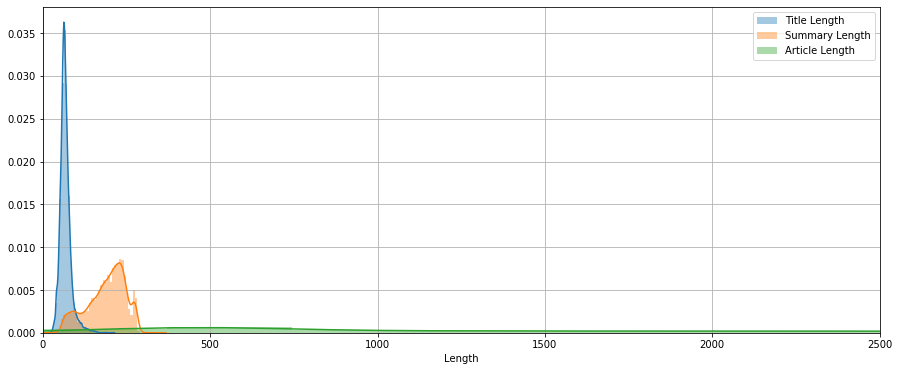

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 6))
sns.distplot(df.title.apply(len), label="Title Length")
sns.distplot(df.summary.apply(len), label="Summary Length")
sns.distplot(df.article.apply(len), label="Article Length")
plt.legend()
plt.xlabel("Length")
plt.xlim((0, 2500))
plt.grid()
plt.show()

In [20]:
df.date.min()

Timestamp('2016-01-28 21:06:00')

In [21]:
df.date.max()

Timestamp('2020-07-18 21:03:00')

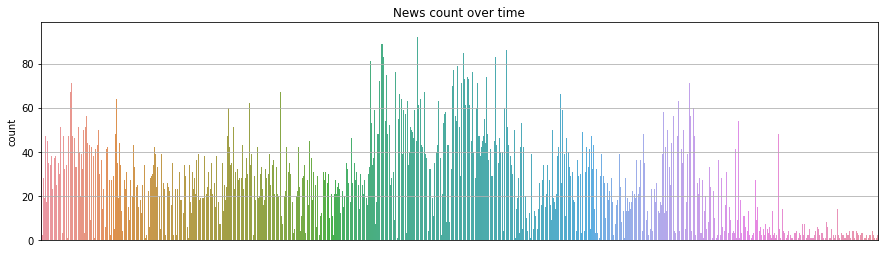

In [22]:
df['date_only'] = df['date'].dt.date
plt.figure(figsize=(15, 4))
sns.countplot(df.date_only)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.xaxis.set_ticklabels([])
plt.title("News count over time")
plt.grid()
plt.show()